# Diffusion

## Diffusion 이란?

이미지에 점진적으로 noise 를 더해가면 결국 완전한 noisy image 가 된다. 그렇다면 noisy image 에서 점진적으로 denoise 를 가하면 원하는 image 를 만들 수 있을 것이다.

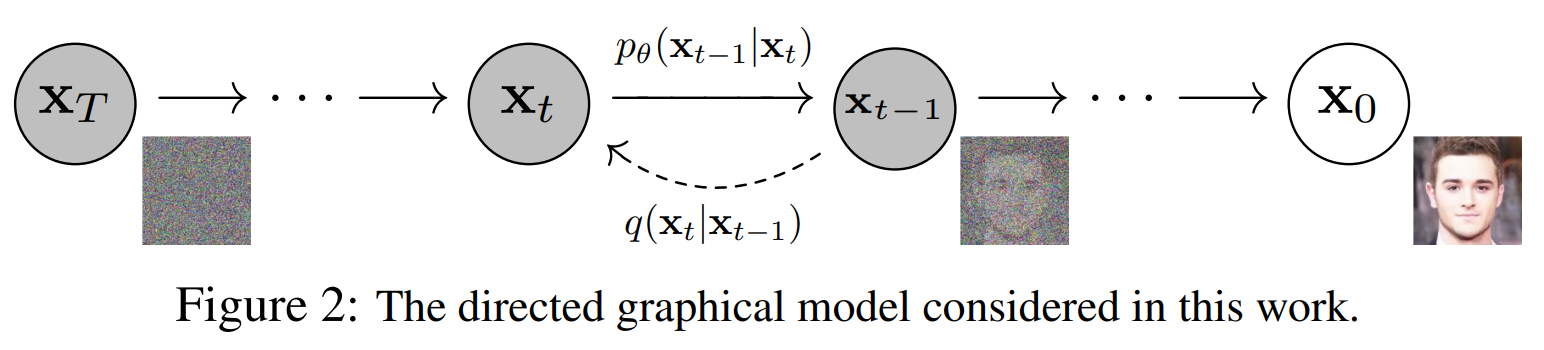

[Deep Unsupervised Learning using Nonequilibrium Thermodynamics : Diffusion model 에 대한 개념을 처음으로 제시](https://arxiv.org/abs/1503.03585)

[Denoising Diffusion Probabilistic Models : 해당 모델구조가 실용적임을 증명한 논문](https://arxiv.org/abs/2006.11239)

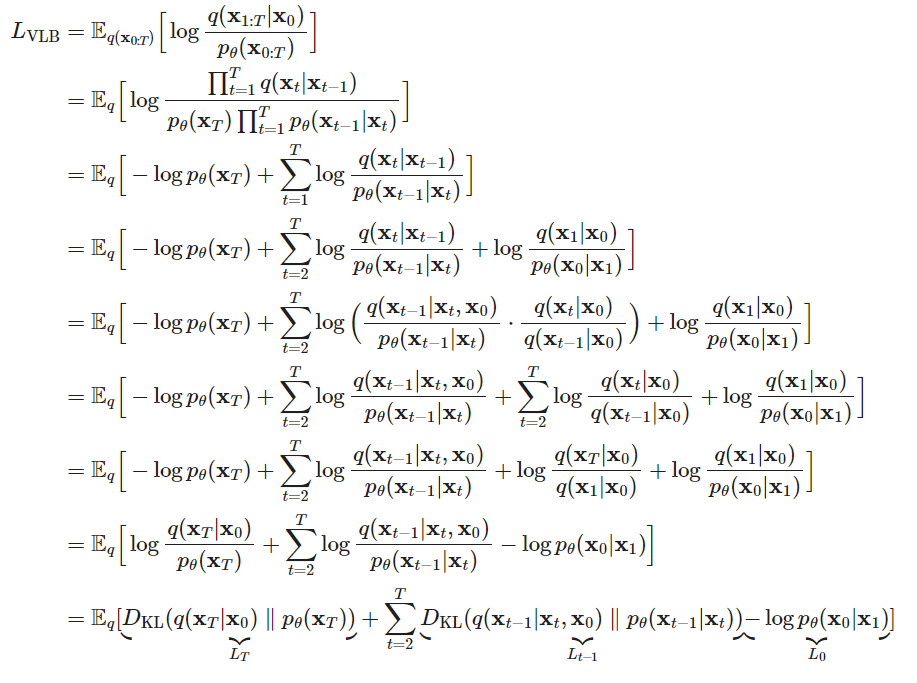

2번째 논문의 loss 증명식으로, 이런게 있구나 정도로 넘어가면 됩니다.

## Code 예제 : DDPM 을 통한 MNIST data 생성

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
batch_size = 128
lr = 2e-4
epoch = 50
timestep = 1000

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [14]:
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]


In [36]:
betas = torch.linspace(1e-4, 0.02, timestep).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [37]:
def extract(a, t, x_shape):
    t_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(t_size, *((1,) * (len(x_shape) - 1)))

In [38]:
class DDPM(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

        self.encoder1 = nn.Conv2d(1, 32, 3, padding=1)
        self.encoder2 = nn.Conv2d(32, 64, 3, padding=1)

        self.decoder1 = nn.Conv2d(64, 32, 3, padding=1)
        self.decoder2 = nn.Conv2d(32, 1, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x, t):
        t = t.float().unsqueeze(-1)
        t_emb = self.time_mlp(t)
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)

        x1 = self.relu(self.encoder1(x))
        x2 = self.relu(self.encoder2(x1))

        x2 = x2 + t_emb.expand(-1, 64, 28, 28)[:, :64, :, :]

        x3 = self.relu(self.decoder1(x2))
        output = self.decoder2(x3)

        return output

In [39]:
model = DDPM().to(device)

In [40]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [41]:
loss_history = []

for i in range(epoch):
  i_loss = 0
  for step, (x_0, _) in enumerate(dataloader):
    optimizer.zero_grad()
    x_0 = x_0.to(device)

    t = torch.randint(0, timestep, (batch_size,), device=device).long()

    noise = torch.randn_like(x_0) # Ans noise 생성

    x_t = (
        extract(sqrt_alphas_cumprod, t, x_0.shape) * x_0 +
        extract(sqrt_one_minus_alphas_cumprod, t, x_0.shape) * noise)

    noise_pred = model(x_t, t)

    loss = F.mse_loss(noise_pred, noise)

    loss.backward()
    optimizer.step()

    i_loss += loss.item()
    if step % 100 == 0:
      print(f"Epoch {i+1} | Step {step}/{len(dataloader)} | Loss: {loss.item():.4f}")

  avg_loss = i_loss / len(dataloader)
  loss_history.append(avg_loss)
  print(f"Epoch {i+1} Finished | Avg Loss: {avg_loss:.4f}")

Epoch 1 | Step 0/468 | Loss: 480.5792
Epoch 1 | Step 100/468 | Loss: 1.3193
Epoch 1 | Step 200/468 | Loss: 0.8837
Epoch 1 | Step 300/468 | Loss: 0.5935
Epoch 1 | Step 400/468 | Loss: 0.3929
Epoch 1 Finished | Avg Loss: 6.6402
Epoch 2 | Step 0/468 | Loss: 0.3190
Epoch 2 | Step 100/468 | Loss: 0.2436
Epoch 2 | Step 200/468 | Loss: 0.2101
Epoch 2 | Step 300/468 | Loss: 0.2483
Epoch 2 | Step 400/468 | Loss: 0.2545
Epoch 2 Finished | Avg Loss: 0.2583
Epoch 3 | Step 0/468 | Loss: 0.5355
Epoch 3 | Step 100/468 | Loss: 0.2061
Epoch 3 | Step 200/468 | Loss: 0.1842
Epoch 3 | Step 300/468 | Loss: 0.3447
Epoch 3 | Step 400/468 | Loss: 1.1198
Epoch 3 Finished | Avg Loss: 0.5721
Epoch 4 | Step 0/468 | Loss: 0.2486
Epoch 4 | Step 100/468 | Loss: 0.1587
Epoch 4 | Step 200/468 | Loss: 0.2158
Epoch 4 | Step 300/468 | Loss: 1.7493
Epoch 4 | Step 400/468 | Loss: 0.1465
Epoch 4 Finished | Avg Loss: 0.7595
Epoch 5 | Step 0/468 | Loss: 0.1766
Epoch 5 | Step 100/468 | Loss: 0.2052
Epoch 5 | Step 200/468 | Los

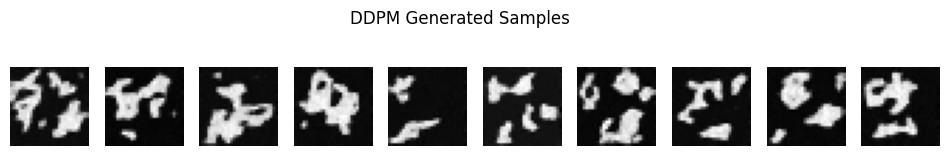

In [42]:
with torch.no_grad():
  img = torch.randn((10, 1, 28, 28), device=device)

  steps_to_show = [0, timestep//4, timestep//2, timestep-1]

  plt.figure(figsize=(12, 2))

  for i in range(timestep-1, -1, -1):
    t = torch.full((10,), i, device=device, dtype=torch.long)
    z = torch.randn_like(img) if i > 0 else torch.zeros_like(img)

    noise_pred = model(img, t)

    alpha_t = extract(alphas, t, img.shape)
    alpha_bar_t = extract(alphas_cumprod, t, img.shape)

    mean = (1 / torch.sqrt(alpha_t)) * (img - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred)

    sigma_t = torch.sqrt(extract(betas, t, img.shape))

    img = mean + sigma_t * z
    for idx in range(10):
      plt.subplot(1, 10, idx+1)
      plt.imshow(img[idx].cpu().squeeze().numpy(), cmap='gray')
      plt.axis('off')
  plt.suptitle("DDPM Generated Samples")
  plt.show()

## Code 예제 : Stable Diffusion model

어쩌면 가장 유명할 Diffusion model. 모델 전체가 오픈소스로 공개됨

[GitHub 링크](https://github.com/CompVis/stable-diffusion)

In [ ]:
!pip install diffusers accelerate

In [2]:
from diffusers import StableDiffusionPipeline
from IPython.display import display

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", dtype=torch.float16)
pipe = pipe.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
prompt = "A high-quality photo of a cowboy on the saturn."

  0%|          | 0/50 [00:00<?, ?it/s]

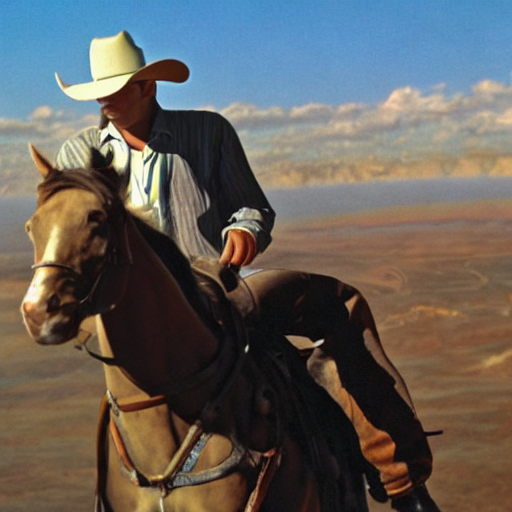

In [9]:
image = pipe(prompt).images[0]
display(image)